<a href="https://colab.research.google.com/github/aseelalzaben03/Task-4/blob/main/Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
dataset_path = '/content/drive/My Drive/data'
print("Files and folders in the dataset path:")
print(os.listdir(dataset_path))

Files and folders in the dataset path:
['images', 'labels', 'converted_images']


In [3]:
images_path='/content/drive/My Drive/data/images'
labels_path='/content/drive/My Drive/data/labels'
print("Images:", os.listdir(images_path))
print("labels data:", os.listdir(labels_path))

Images: ['194.tif', '184.tif', '80.tif', '36.tif', '172.tif', '245.tif', '24.tif', '66.tif', '1.tif', '193.tif', '70.tif', '136.tif', '271.tif', '0.tif', '3.tif', '25.tif', '35.tif', '283.tif', '77.tif', '63.tif', '209.tif', '94.tif', '257.tif', '57.tif', '277.tif', '227.tif', '282.tif', '156.tif', '177.tif', '280.tif', '178.tif', '27.tif', '204.tif', '300.tif', '117.tif', '67.tif', '50.tif', '214.tif', '73.tif', '61.tif', '252.tif', '78.tif', '215.tif', '9.tif', '132.tif', '100.tif', '297.tif', '133.tif', '122.tif', '37.tif', '10.tif', '40.tif', '223.tif', '152.tif', '241.tif', '181.tif', '115.tif', '188.tif', '89.tif', '270.tif', '46.tif', '42.tif', '84.tif', '203.tif', '265.tif', '107.tif', '38.tif', '180.tif', '22.tif', '161.tif', '196.tif', '56.tif', '140.tif', '105.tif', '264.tif', '267.tif', '195.tif', '289.tif', '304.tif', '232.tif', '255.tif', '278.tif', '219.tif', '52.tif', '269.tif', '160.tif', '6.tif', '79.tif', '127.tif', '112.tif', '18.tif', '58.tif', '234.tif', '86.tif',

## Preprocessing and Visualization


In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [6]:
def load_multispectral_image(image_path):
    """Loads a multispectral image while maintaining its original shape and resolution."""
    with rasterio.open(image_path) as src:
        image = src.read()  # Read all bands
        profile = src.profile  # Preserve metadata
    return image, profile

def normalize_image(image):
    """Applies Min-Max normalization across all bands."""
    normalized_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):  # Iterate over bands
        band = image[i]
        min_val, max_val = band.min(), band.max()
        normalized_image[i] = (band - min_val) / (max_val - min_val + 1e-8)  # Avoid division by zero
    return normalized_image


In [7]:
def visualize_bands(image, bands=(0, 1, 2), title="RGB Composite"):
    """Visualizes selected bands as an RGB composite."""
    rgb_image = np.stack([image[b] for b in bands], axis=-1)
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [8]:
import cv2

def denoise_image(image):
    """Apply Gaussian blur to remove noise while preserving edges."""
    denoised_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):  # Apply per band
        denoised_image[i] = cv2.GaussianBlur(image[i], (5, 5), 0)
    return denoised_image


In [9]:
def remove_clouds(image, threshold=0.8):
    """Mask out clouds based on NIR band intensity."""
    nir_band = image[3]  # Assuming NIR is the 4th band
    mask = nir_band < threshold  # Create a mask (low NIR = cloud)
    return image * mask  # Apply mask

In [10]:
from skimage.exposure import match_histograms

def match_histogram(source, reference):
    """Match histogram of source image to reference image."""
    matched = np.zeros_like(source)
    for i in range(source.shape[0]):
        matched[i] = match_histograms(source[i], reference[i], multichannel=False)
    return matched


In [11]:
from skimage.transform import resize

def resample_image(image, target_shape):
    """Resizes image to match target shape."""
    resampled = np.zeros((image.shape[0], target_shape[0], target_shape[1]), dtype=np.float32)
    for i in range(image.shape[0]):
        resampled[i] = resize(image[i], target_shape, mode='reflect', anti_aliasing=True)
    return resampled

In [12]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

def augment_image(image):
    """Applies random augmentations."""
    augmented = transform(image=image.transpose(1, 2, 0))["image"]
    return augmented.transpose(2, 0, 1)  # Convert back to (C, H, W)


In [13]:
def preprocess_image(image, reference=None, target_shape=None):
    """Full preprocessing pipeline for water segmentation."""
    image = normalize_image(image)  # Step 1: Normalize
    image = denoise_image(image)    # Step 2: Denoise
    if reference is not None:
        image = match_histogram(image, reference)  # Step 3: Histogram Matching
    if target_shape is not None:
        image = resample_image(image, target_shape)  # Step 4: Resampling
    image = augment_image(image)  # Step 5: Data Augmentation
    return image


In [14]:
def visualize_comparison(original, preprocessed, filename, bands=(0, 1, 2)):
    """Displays original and preprocessed images side by side."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Convert multispectral to RGB format
    orig_rgb = np.stack([original[b] for b in bands], axis=-1)
    preproc_rgb = np.stack([preprocessed[b] for b in bands], axis=-1)

    # Display original
    axes[0].imshow(orig_rgb)
    axes[0].set_title(f"Original Image: {filename}")
    axes[0].axis("off")

    # Display preprocessed
    axes[1].imshow(preproc_rgb)
    axes[1].set_title(f"Preprocessed Image: {filename}")
    axes[1].axis("off")

    plt.show()

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


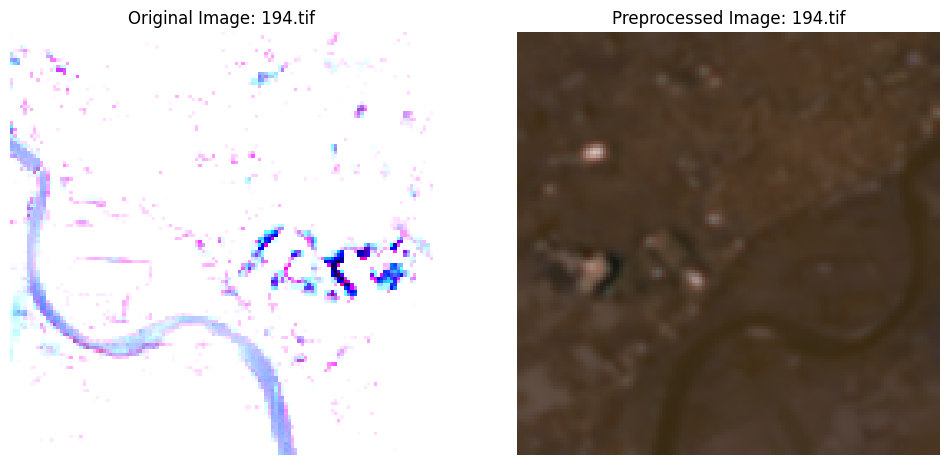

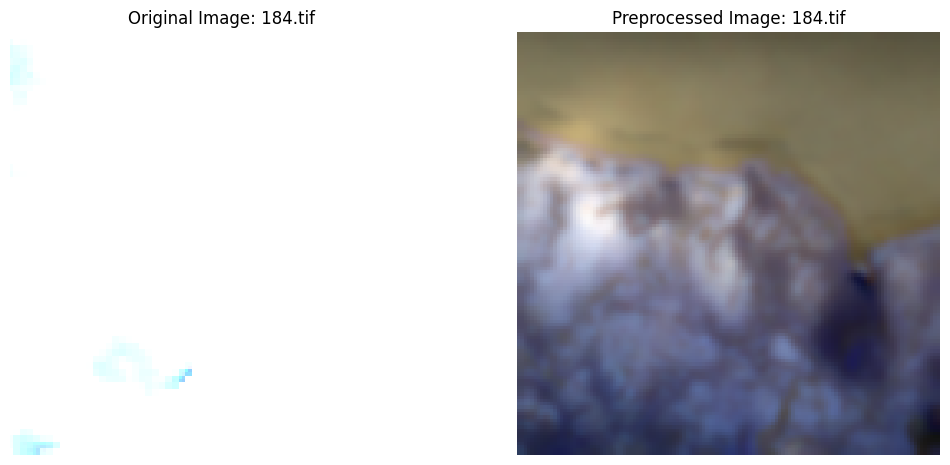

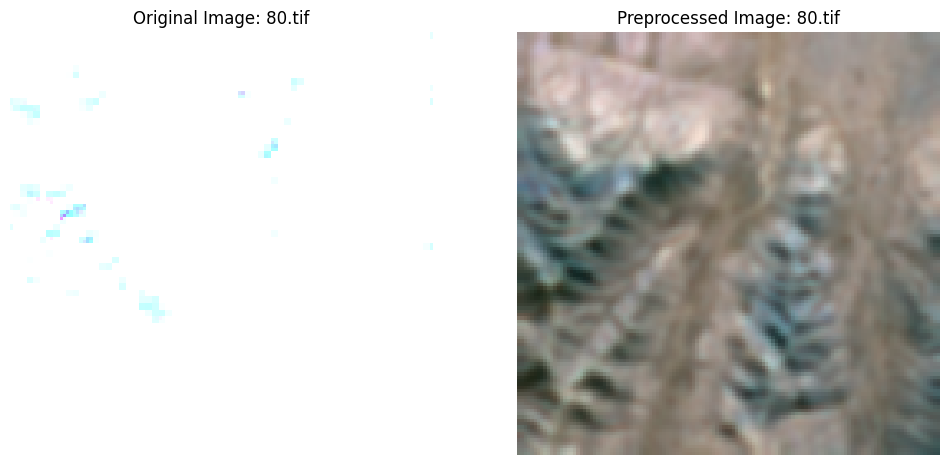

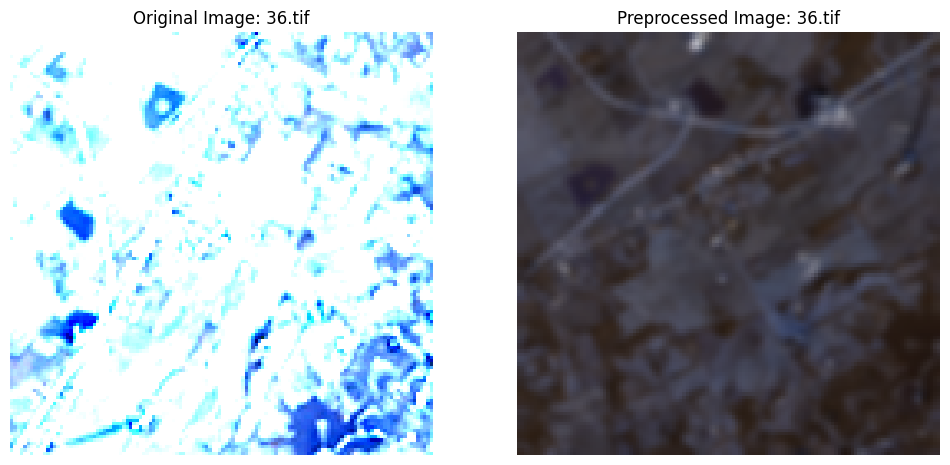

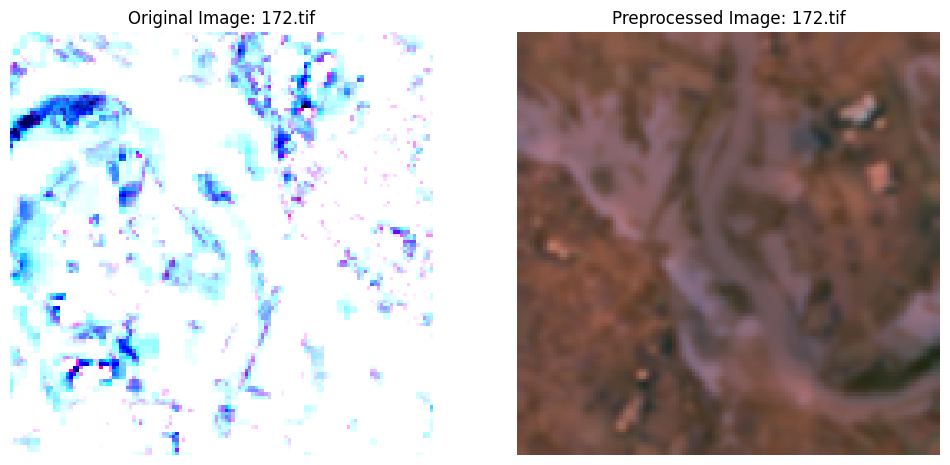

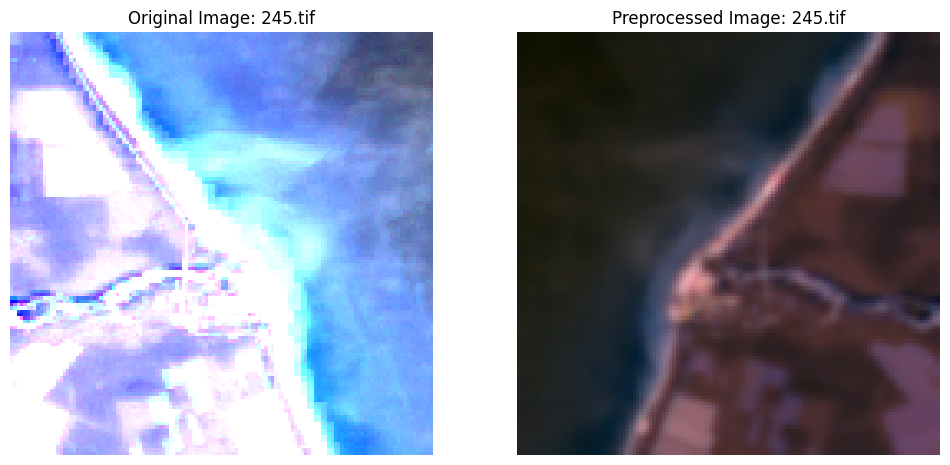

In [15]:
images_path = "/content/drive/My Drive/data/images"
max_images = 6  # Limit the number of images to display
count = 0

for filename in os.listdir(images_path):
    if filename.endswith(('.tif', '.tiff', '.geotiff')):
        image_path = os.path.join(images_path, filename)  # Construct full image path

        # Load and preprocess image
        image, metadata = load_multispectral_image(image_path)
        preprocessed_image = preprocess_image(image)

        # Show comparison
        visualize_comparison(image, preprocessed_image, filename)

        count += 1
        if count >= max_images:  # Stop after displaying max_images
            break


In [16]:
def visualize_bands(image, title=""):
    """Displays each band of the multispectral image separately."""
    num_bands = image.shape[2]  # Assuming the image has (height, width, bands)
    fig, axes = plt.subplots(1, num_bands, figsize=(num_bands * 4, 4))

    if num_bands == 1:
        axes = [axes]

    for i in range(num_bands):
        ax = axes[i]
        band_image = image[:, :, i]
        im = ax.imshow(band_image, cmap="gray")
        ax.set_title(f"Band {i+1}")
        ax.axis("off")
        plt.colorbar(im, ax=ax)

    # Add the title for the whole plot
    plt.suptitle(title)
    plt.show()


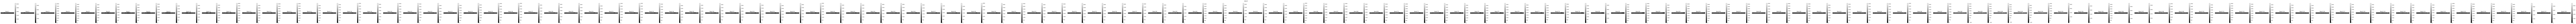

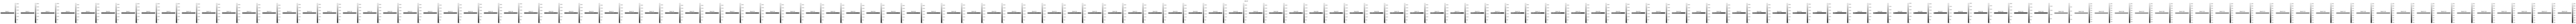

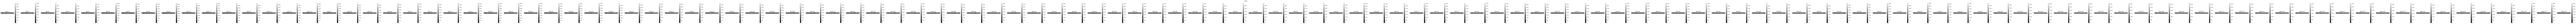

In [17]:
images_path = "/content/drive/My Drive/data/images"
max_images = 3 # Limit the number of images displayed
count = 0

for filename in os.listdir(images_path):
    if filename.endswith(('.tif', '.tiff', '.geotiff')):
        image_path = os.path.join(images_path, filename)  # Construct full image path

        # Load image
        image, metadata = load_multispectral_image(image_path)

        # Show band-wise visualization
        visualize_bands(image, filename)

        count += 1
        if count >= max_images:  # Stop after displaying max_images
            break


## Modeling

In [18]:
!pip uninstall keras -y
!pip install tensorflow

Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.4 MB/s eta 0:00:00


In [19]:
pip install --upgrade tensorflow


In [60]:

import os
import cv2
import numpy as np
import rasterio
from rasterio.plot import show

# Define paths
images_path = "/content/drive/My Drive/data/images"
label_dir = "/content/drive/My Drive/data/labels"

images = []  # List to store images
labels = []  # List to store labels (masks)

# Get a list of label filenames (without extensions)
label_files = {os.path.splitext(f)[0]: f for f in os.listdir(label_dir) if f.endswith(".png")}

# Loop over image files
for image_file in os.listdir(images_path):
    if image_file.endswith(('.tif', '.tiff', '.geotiff')):  # Check if file is an image (tif format)
        image_path = os.path.join(images_path, image_file)  # Full path to image file

        try:
            # Load the image using rasterio (supports multi-band TIFF)
            with rasterio.open(image_path) as src:
                image = src.read()  # Read all bands
                image = np.moveaxis(image, 0, -1)  # Reorder dimensions to (height, width, channels)

            # Check if the image loaded successfully
            if image is None:
                print(f"Failed to load image: {image_file}")
                continue  # Skip this image if it fails to load

            print(f"Successfully loaded image: {image_file}")

            # Normalize image (you can adjust this step depending on your requirements)
            normalized_image = image / 255.0  # Normalize pixel values to [0, 1]

            # Generate expected label filename (without .tif extension)
            image_name = os.path.splitext(image_file)[0]  # Remove .tif or .tiff extension
            label_file = label_files.get(image_name)  # Get corresponding .png label

            if label_file is None:
                print(f"Label file not found for image: {image_file}")
                continue  # Skip if label not found

            label_path = os.path.join(label_dir, label_file)

            # Load the label
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

            if label is None:
                print(f"Failed to load label for {image_file}")
                continue  # Skip if label fails to load

            # Resize label to match the image size
            label_resized = cv2.resize(label, (128, 128))  # Adjust size if needed
            label_resized = np.expand_dims(label_resized, axis=-1)  # Add channel dimension for compatibility

            # Append to the lists
            labels.append(label_resized)
            images.append(normalized_image)

        except Exception as e:
            print(f"Error loading image {image_file}: {e}")
            continue  # Skip this image if an error occurs

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Successfully loaded image: 194.tif
Successfully loaded image: 184.tif
Successfully loaded image: 80.tif
Successfully loaded image: 36.tif
Successfully loaded image: 172.tif
Successfully loaded image: 245.tif
Successfully loaded image: 24.tif
Successfully loaded image: 66.tif
Successfully loaded image: 1.tif
Successfully loaded image: 193.tif
Successfully loaded image: 70.tif
Successfully loaded image: 136.tif
Successfully loaded image: 271.tif
Successfully loaded image: 0.tif
Successfully loaded image: 3.tif
Successfully loaded image: 25.tif
Successfully loaded image: 35.tif
Successfully loaded image: 283.tif
Successfully loaded image: 77.tif
Successfully loaded image: 63.tif
Successfully loaded image: 209.tif
Successfully loaded image: 94.tif
Successfully loaded image: 257.tif
Successfully loaded image: 57.tif
Successfully loaded image: 277.tif
Successfully loaded image: 227.tif
Successfully loaded image: 282.tif
Successfully loaded image: 156.tif
Successfully loaded image: 177.tif
Su

In [61]:
import imageio
import os

images_path = "/content/drive/My Drive/data/images"

for image_file in os.listdir(images_path):
    if image_file.endswith(('.tif', '.tiff', '.geotiff')):
        image_path = os.path.join(images_path, image_file)
        try:
            image = imageio.imread(image_path)
            print(f"Successfully loaded image: {image_file}")
        except Exception as e:
            print(f"Failed to load image: {image_file}, Error: {e}")

Successfully loaded image: 194.tif
Successfully loaded image: 184.tif
Successfully loaded image: 80.tif
Successfully loaded image: 36.tif
Successfully loaded image: 172.tif
Successfully loaded image: 245.tif
Successfully loaded image: 24.tif
Successfully loaded image: 66.tif
Successfully loaded image: 1.tif
Successfully loaded image: 193.tif
Successfully loaded image: 70.tif
Successfully loaded image: 136.tif
Successfully loaded image: 271.tif
Successfully loaded image: 0.tif
Successfully loaded image: 3.tif
Successfully loaded image: 25.tif
Successfully loaded image: 35.tif
Successfully loaded image: 283.tif
Successfully loaded image: 77.tif
Successfully loaded image: 63.tif
Successfully loaded image: 209.tif
Successfully loaded image: 94.tif
Successfully loaded image: 257.tif
Successfully loaded image: 57.tif
Successfully loaded image: 277.tif
Successfully loaded image: 227.tif
Successfully loaded image: 282.tif
Successfully loaded image: 156.tif
Successfully loaded image: 177.tif
Su

<ipython-input-61-de6fa71b3849>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


Successfully loaded image: 122.tif
Successfully loaded image: 37.tif
Successfully loaded image: 10.tif
Successfully loaded image: 40.tif
Successfully loaded image: 223.tif
Successfully loaded image: 152.tif
Successfully loaded image: 241.tif
Successfully loaded image: 181.tif
Successfully loaded image: 115.tif
Successfully loaded image: 188.tif
Successfully loaded image: 89.tif
Successfully loaded image: 270.tif
Successfully loaded image: 46.tif
Successfully loaded image: 42.tif
Successfully loaded image: 84.tif
Successfully loaded image: 203.tif
Successfully loaded image: 265.tif
Successfully loaded image: 107.tif
Successfully loaded image: 38.tif
Successfully loaded image: 180.tif
Successfully loaded image: 22.tif
Successfully loaded image: 161.tif
Successfully loaded image: 196.tif
Successfully loaded image: 56.tif
Successfully loaded image: 140.tif
Successfully loaded image: 105.tif
Successfully loaded image: 264.tif
Successfully loaded image: 267.tif
Successfully loaded image: 195

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.regularizers import l2

def unet_pretrained(input_size=(128, 128, 12)):
    inputs = layers.Input(shape=input_size)

    # Reduce 12 channels to 3 before passing to EfficientNet
    x = layers.Conv2D(3, (1, 1), activation='relu', padding='same')(inputs)

    # Load EfficientNetB4 as the encoder
    base_model = EfficientNetB4(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    base_output = base_model(x)

    # U-Net Decoder (with regularization & dropout)
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=l2(0.0001))(base_output)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
    x = layers.Dropout(0.3)(x)  # Dropout added

    x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=l2(0.0001))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

model = unet_pretrained()
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 3)         │              39 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 4, 4, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 8, 8, 512)           │       3,670,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 16, 16, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 64, 64, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 128, 128, 32)        │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 1)         │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,184,871 (96.07 MB)

 Trainable params: 25,059,664 (95.60 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [63]:
print(f"Number of layers in the current model: {len(model.layers)}")


Number of layers in the current model: 16


In [64]:
print(model.input_shape)  # Check if it's (None, 128, 128, 12)



(None, 128, 128, 12)


In [65]:
print(model.name)  # Prints the model's name
print(model.input)  # Prints input layer details



functional_1
<KerasTensor shape=(None, 128, 128, 12), dtype=float32, sparse=False, name=keras_tensor_493>


In [66]:
import os
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Paths to images and labels
images_path = "/content/drive/My Drive/data/images"
labels_path = "/content/drive/My Drive/data/labels"

# Load a single multispectral image
def load_multispectral_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
    return image

# Load a single label image
def load_label(label_path):
    with rasterio.open(label_path) as src:
        label = src.read(1)  # Read first band (grayscale)
    return label

# Load dataset
def load_dataset(image_dir, label_dir, target_size=(128, 128)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))

    for img_file, lbl_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        lbl_path = os.path.join(label_dir, lbl_file)

        # Load and preprocess
        image = load_multispectral_image(img_path)
        mask = load_label(lbl_path)

        # Resize
        image = tf.image.resize(image.transpose(1, 2, 0), target_size).numpy()
        mask = tf.image.resize(mask[..., np.newaxis], target_size, method='nearest').numpy()

        # Normalize
        image = image / 255.0  # Scale to [0,1]
        mask = (mask > 0).astype(np.float32)  # Convert to binary

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load data
X, Y = load_dataset(images_path, labels_path)
print(f"Dataset shape: Images {X.shape}, Masks {Y.shape}")


Dataset shape: Images (306, 128, 128, 12), Masks (306, 128, 128, 1)


In [67]:
from sklearn.model_selection import train_test_split

# Split dataset (80% Train, 20% Test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}, {Y_train.shape}")
print(f"Testing data: {X_test.shape}, {Y_test.shape}")


Training data: (244, 128, 128, 12), (244, 128, 128, 1)
Testing data: (62, 128, 128, 12), (62, 128, 128, 1)


In [68]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_resized = tf.image.resize(Y_train, (128, 128), method="nearest")
Y_train_resized = tf.convert_to_tensor(Y_train_resized, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_resized = tf.image.resize(Y_test, (128, 128), method="nearest")
Y_test_resized = tf.convert_to_tensor(Y_test_resized, dtype=tf.float32)

print("X_train dtype:", X_train.dtype)
print("Y_train_resized dtype:", Y_train_resized.dtype)


X_train dtype: <dtype: 'float32'>
Y_train_resized dtype: <dtype: 'float32'>


In [69]:
# Convert data to TensorFlow tensors if needed
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_resized = tf.convert_to_tensor(Y_train_resized, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_resized = tf.convert_to_tensor(Y_test_resized, dtype=tf.float32)


In [70]:
print("X_train shape:", X_train.shape)
print("Y_train_resized shape:", Y_train_resized.shape)
print("X_test shape:", X_test.shape)
print("Y_test_resized shape:", Y_test_resized.shape)


X_train shape: (244, 128, 128, 12)
Y_train_resized shape: (244, 128, 128, 1)
X_test shape: (62, 128, 128, 12)
Y_test_resized shape: (62, 128, 128, 1)


In [71]:

# Check for NaN or Inf in the data
print("NaN in X_train:", np.isnan(X_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())

print("NaN in Y_train_resized:", np.isnan(Y_train_resized).sum())
print("Inf in Y_train_resized:", np.isinf(Y_train_resized).sum())


NaN in X_train: 0
Inf in X_train: 0
NaN in Y_train_resized: 0
Inf in Y_train_resized: 0


In [72]:
print(f'X_train shape: {X_train.shape}, dtype: {X_train.dtype}')
print(f'Y_train_resized shape: {Y_train_resized.shape}, dtype: {Y_train_resized.dtype}')


X_train shape: (244, 128, 128, 12), dtype: <dtype: 'float32'>
Y_train_resized shape: (244, 128, 128, 1), dtype: <dtype: 'float32'>


In [73]:
print("X_train shape:", X_train.shape)
print("Y_train_resized shape:", Y_train_resized.shape)
print("X_test shape:", X_test.shape)
print("Y_test_resized shape:", Y_test_resized.shape)

print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))


X_train shape: (244, 128, 128, 12)
Y_train_resized shape: (244, 128, 128, 1)
X_test shape: (62, 128, 128, 12)
Y_test_resized shape: (62, 128, 128, 1)
Number of training samples: 244
Number of testing samples: 62


In [74]:
for x, y in train_dataset.take(1):
    print("Sample Input Shape:", x.shape)
    print("Sample Target Shape:", y.shape)


Sample Input Shape: (32, 128, 128, 12)
Sample Target Shape: (32, 128, 128, 1)


In [75]:
def augment(image, mask):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, mask


In [76]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train_resized))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test_resized))

# Ensure tensors are properly batched and prefetched
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [77]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-3)


In [78]:

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 261s 14s/step - accuracy: 0.6412 - loss: 0.8619 - val_accuracy: 0.6278 - val_loss: 0.8334 - learning_rate: 5.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.7157 - loss: 0.7812 - val_accuracy: 0.6278 - val_loss: 0.8290 - learning_rate: 5.0000e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.6936 - loss: 0.7622 - val_accuracy: 0.6278 - val_loss: 0.8316 - learning_rate: 5.0000e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.7000 - loss: 0.7499 - val_accuracy: 0.6278 - val_loss: 0.8778 - learning_rate: 5.0000e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.6906 - loss: 0.7304 - val_accuracy: 0.6278 - val_loss: 0.8006 - learning_rate: 5.0000e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.7061 - loss: 0.7032 - val_accuracy: 0.6278 - val_loss: 0.8030 - learning_rate: 5.0000e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.7052 

## Evaluation

In [80]:
# Evaluate performance
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6143 - loss: 0.7665
Test Accuracy: 0.6278


2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 11s/step


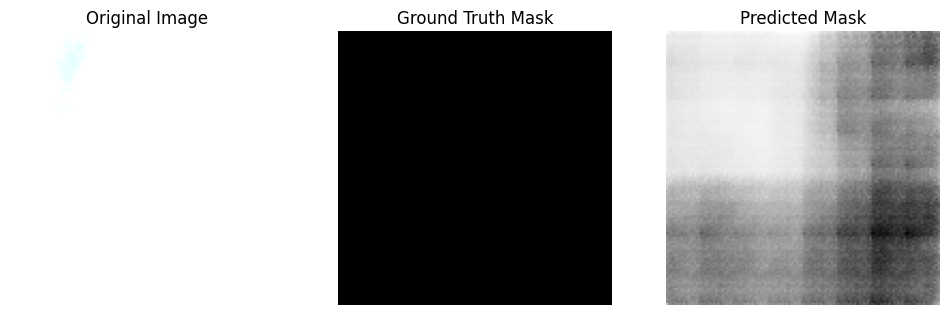

In [81]:
import matplotlib.pyplot as plt

# Predict on test images
preds = model.predict(X_test)

# Display original, ground truth, and predicted mask
def visualize_results(index):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    # Original Image (RGB bands)
    axes[0].imshow(X_test[index][..., :3])  # Show first 3 bands
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Ground Truth Mask
    axes[1].imshow(Y_test[index].squeeze(), cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Predicted Mask
    axes[2].imshow(preds[index].squeeze(), cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

# Visualize results for a random test image
visualize_results(5)


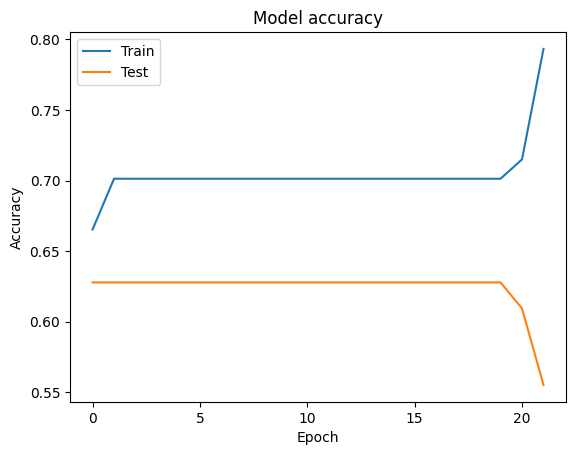

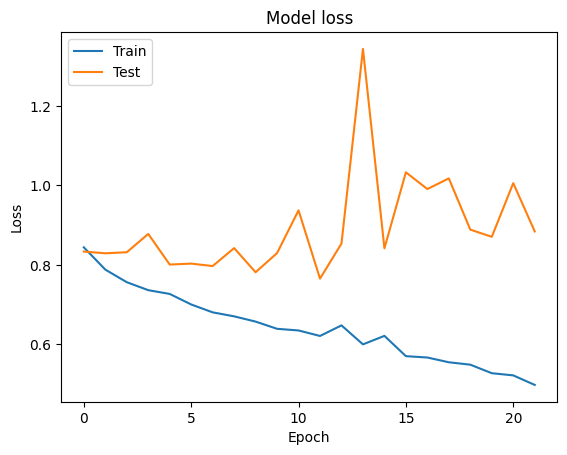

In [82]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
